In [1]:
import numpy as np
import scipy.signal as signal
import scipy.fftpack as fftpack
import random
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append("../")
from mfilter.regressions import *
from mfilter.types import FrequencySamples, TimeSeries, FrequencySeries, TimesSamples
from mfilter.filter import *

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


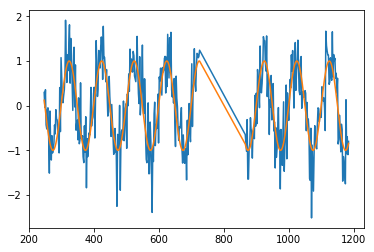

In [2]:
# times
delta_t = 2.0
n = 400
struct = "automix"
freq = 0.01
sqvar = 0.5
times = TimesSamples(initial_array=None, n=n, delta=delta_t, struct=struct)
data = np.sin(2 * np.pi * freq * times)
noise = np.random.normal(0, sqvar, n)
S = TimeSeries(data+noise, times=times)
T = TimeSeries(data, times=times)
N = TimeSeries(noise, times=times)
plt.plot(times, S)
plt.plot(times, T)

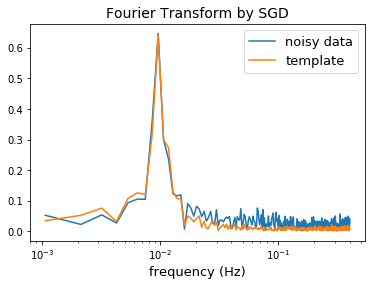

In [3]:
# define freq
gamma = 1
min_freq = 1/S.duration/gamma
max_freq = len(times) / 2 / S.duration 
max_freq = 0.4
freqs = FrequencySamples(input_time=times, 
                         minimum_frequency=min_freq, 
                         maximum_frequency=max_freq, 
                         samples_per_peak=gamma)

# define regressor
reg = SGDRegression(alpha=10**(-4), max_iter=100)
reg.create_dict(times, freqs)

reg.reset()
FS = S.to_frequencyseries(reg=reg)
reg.reset()
FT = T.to_frequencyseries(reg=reg)
reg.reset()
FN = N.to_frequencyseries(reg=reg)

plt.semilogx(freqs, abs(FS), label="noisy data")
plt.semilogx(freqs, abs(FT), label="template")
plt.title("Fourier Transform by SGD", fontsize=14)
plt.xlabel("frequency (Hz)", fontsize=13)
plt.legend(fontsize=13)


Text(0.5,1,'Averaged Noise PSD from data')

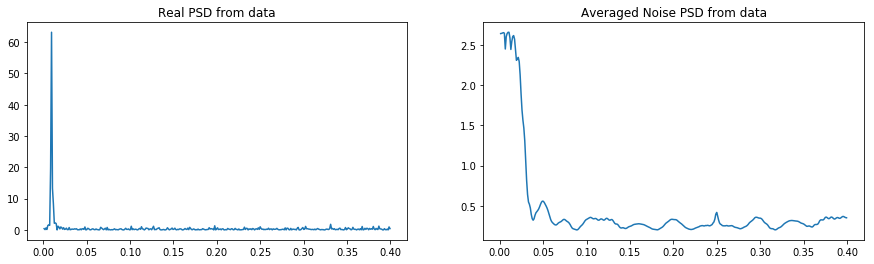

In [4]:
true_psd = freqs.lomb_scargle(times, S, norm="psd", windowed=False, weighted=False)
psd = freqs.lomb_welch(times, S, len(times)//20, 0.5, norm="psd", weighted=False, windowed=False)
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15, 4))
ax1.plot(freqs, true_psd)
ax2.plot(freqs, psd)
ax1.set_title("Real PSD from data")
ax2.set_title("Averaged Noise PSD from data")

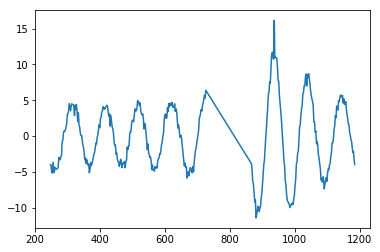

In [5]:
plt.plot(times, np.real(mfilter(times, FS, FT, reg, psd=psd)))

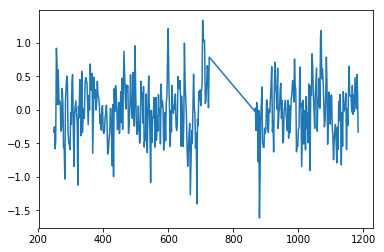

In [6]:
plt.plot(times, np.real(mfilter(times, FN, FT, reg, psd=psd)))